In [1]:
%matplotlib inline
import hyperspy.api as hs
import pyxem as pxm
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import blob_log
from pathlib import Path
from diffsims.utils.sim_utils import get_electron_wavelength

In [2]:
def camera_length(beam_energy, scale, pixel_size):
    """
    Return the cameralength in cm
    
    Arguments
    ---------
    beam_energy: Acceleration voltage in kV
    scale: Diffraction pattern scale in 1/Å
    pixel_size: Detector pixel size in um
    
    Returns:
    --------
    camera_length: Camera length in cm
    """
    return pixel_size/(scale*get_electron_wavelength(beam_energy))*1E-4

# Dataset A
This dataset of a 2xxx series aluminium sample in the $[100]$ zone axis was acquired on a JEOL 2100F operated at 200 kV using DigiStar and the P1000 scan generator from NanoMegas. A Merlin EM 1S (Quantum detectors) was used to acquire the diffraction patterns. The nominal parameters for the acquisition were:
|Parameter|Value|
|---------|-----|
|Camera length| 12 cm|
|Mode|NBD|
|Spotsize| 1.3 nm|
|Alpha (condenser minilens)|5|
|Stepsize|2.778 nm|
|Scan rotation|0$^{\circ}$|
|Precession angle| 1.00$^{\circ}$|
|Precession frequency| 100 Hz|
|Exposure time|10 ms|

## Load dataset
Load the dataset, slice it to ROI and set the diffraction calibration

In [3]:
filename = Path(r'Dataset A\datasetA.mib') #Path to the dataset

In [4]:
s = pxm.load_mib(str(filename), reshape=False)
data = s.data.reshape(600, 600, 256, 256) #Reshape the data
data = data.rechunk(32, 32, 32, 32) #Rechunk the data for "better" processing speeds
s = pxm.signals.LazyElectronDiffraction2D(data) #Recreate a signal from the reshaped data
hdr = filename.with_suffix('.hdr').read_text() #Load the .hdr file
s.original_metadata.add_dictionary({'HDR': hdr}) #Add the .hdr file to the metadata
s.original_metadata.add_dictionary(
    {'NominalParameters': {
        'CL': 12,
        'Mode': 'NBD',
        'Spotsize': 1.3,
        'Alpha': 5,
        'StepSize': (2.778, 2.778),
        'ScanRotation': 0,
        'PrecessionAngle': 1.00,
        'PrecessionFrequency': 100,
    }}) #Add nominal data acquisition parameters to the metadata 
s.metadata.General.title = 'Dataset A' #Update the title of the dataset
s = s.inav[:512, :512] #Select first 512 probe positions in x and y

C:\Users\emilc\Miniconda3\envs\pyxem0.14.2\lib\site-packages\IPython\core\interactiveshell.py:3373: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  if await self.run_code(code, result, async_=asy):
C:\Users\emilc\Miniconda3\envs\pyxem0.14.2\lib\site-packages\IPython\core\interactiveshell.py:3433: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape

Set experimental parameters

In [5]:
beam_energy = 200 #kV
diffraction_scale = 0.00952 #Å^-1
pixel_size = 55 #um
s.set_experimental_parameters(beam_energy=beam_energy, 
                              camera_length=camera_length(beam_energy, diffraction_scale, pixel_size), 
                              scan_rotation=0, 
                              rocking_angle=1.04, 
                              rocking_frequency=100, 
                              exposure_time=10) #Set the experimental parameters. Actual precession angle is slightly different than nominal angle.
s.set_scan_calibration(2.4943) #Set the scan calibration to the calibrated scale (from comparison to TEM image in a seperate workflow).
s.set_diffraction_calibration(diffraction_scale) #Set the diffraction calibration (measured on the dataset)

Load a short scan where the beam was not de-rocked below the sample to show the precession ring.

Frame exposure times are not appearing in header!
This mib file appears to be TEM data. The stack is returned with no reshaping.
[##########                              ] | 25% Completed | 121.39 ms

C:\Users\emilc\Miniconda3\envs\pyxem0.14.2\lib\site-packages\dask\array\rechunk.py:770: UserWarning: chunk size balancing not possible with given chunks. Try increasing the chunk size.
  warn(


[########################################] | 100% Completed | 360.07 ms


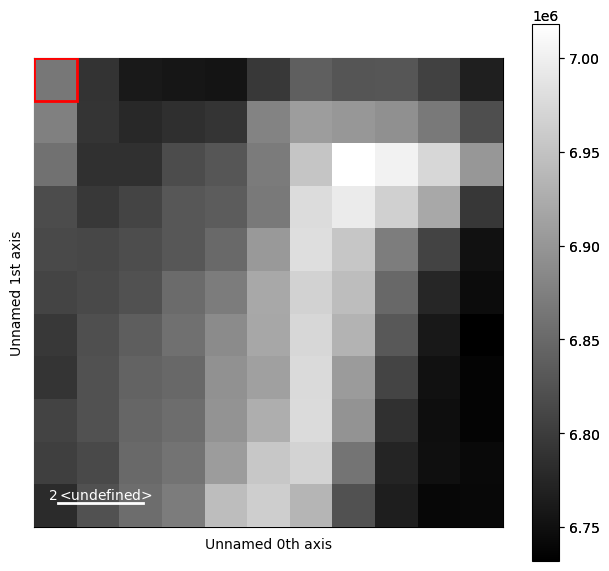

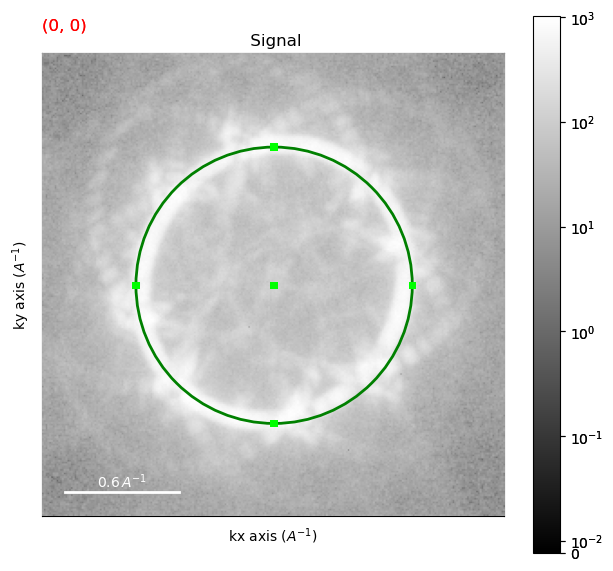

In [6]:
descan_off = pxm.load_mib(str(filename.with_stem(r'datasetA_descanOff'))) #Load the descan_off data
data = descan_off.data.reshape((11, 11, 256, 256)) #Reshape the data
data = data.rechunk(11, 11, 256, 256) #Rechunk the data
descan_off = pxm.signals.LazyElectronDiffraction2D(data) #Recreate the data with correct shape
descan_off.set_diffraction_calibration(diffraction_scale) #Set the diffracton scale
descan_off.compute() #Load the data into memory
descan_off.plot(norm='symlog') #Plot the data
roi = hs.roi.CircleROI(0.0, 0.0, s.metadata.Acquisition_instrument.TEM.rocking_angle*np.pi/180/get_electron_wavelength(200)) #Create a circle with radius equal to the precession angle
roi.add_widget(descan_off, axes=[2, 3]) #Add the circle to the plot
s.original_metadata.add_dictionary({'SupportingData': {'PrecessionRing': descan_off}}) #Add the descan off data to the metadata

In [7]:
tem_image = hs.load(r'Dataset A/TEMBF.dm3')
s.original_metadata.add_dictionary({'SupportingData': {'TEMBF': tem_image}})

In [8]:
s.save(filename.with_suffix('.hspy'), chunks = s.data.chunksize, overwrite=True) #Save the dataset in .hspy (hdf5) format

In [9]:
s = hs.load(filename.with_suffix('.hspy'), lazy=True) #Reload the dataset

[########################################] | 100% Completed | 2.70 sms


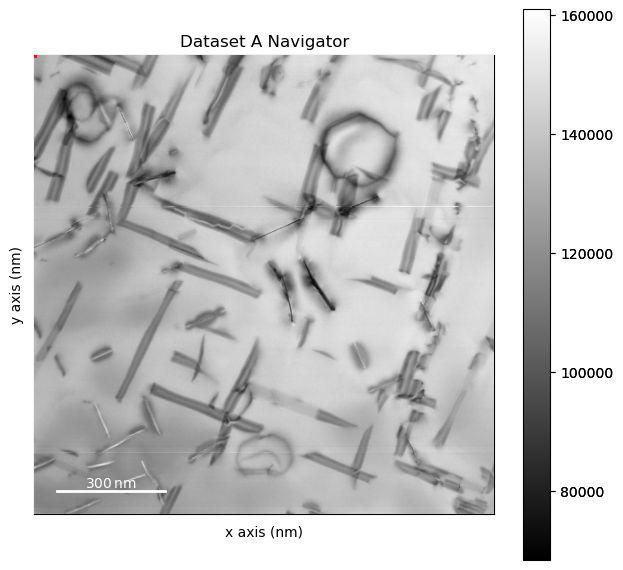

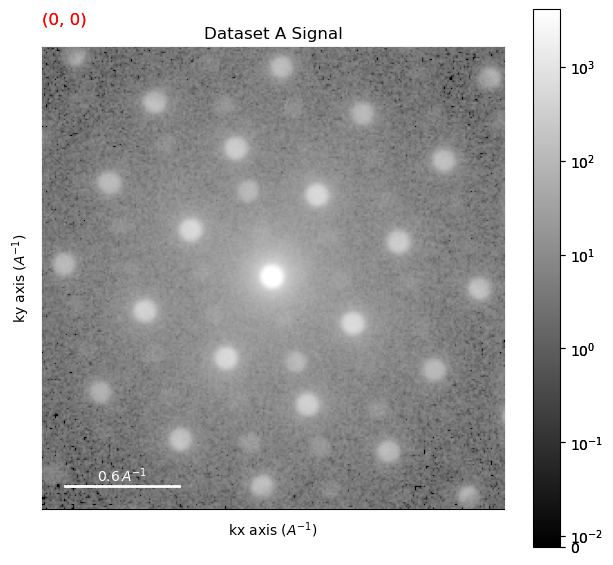

In [10]:
s.plot(norm='symlog') #plot the data with a symlog normalization

## "Correct" linear beam tilt/shift impurity 
(make the direct beam position more stable)

[########################################] | 100% Completed | 130.99 s
[########################################] | 100% Completed | 206.92 s
Beam shift X = ([-1.30769296], [0.18641026])
Beam shift Y = ([-1.98940009], [-1.11251407])
[########################################] | 100% Completed | 155.66 s


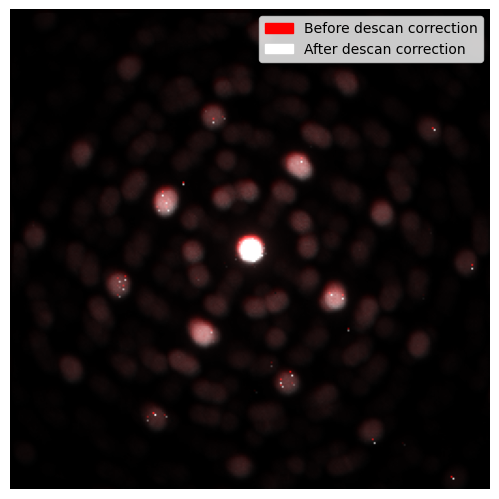

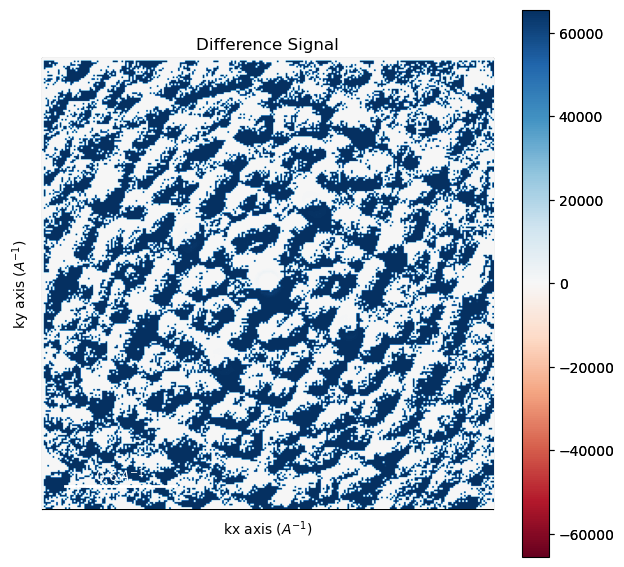

In [11]:
old_max = s.max(axis=[0, 1])
old_max.compute()
old_max.metadata.General.title = 'Before descan correction'
com_mask = (127, 126, 12.5)
com = s.center_of_mass(mask=com_mask)
beam_shift = pxm.signals.BeamShift(com.T)
mask = hs.signals.Signal2D(np.zeros(s.axes_manager.navigation_shape, dtype=bool).T).T
mask.inav[20:-20, 20:-20] = True
beam_shift.make_linear_plane(mask=mask)
beam_shift = beam_shift - (s.axes_manager.signal_shape[0] / 2.0)
print(f'Beam shift X = ({beam_shift.isig[0].min().data}, {beam_shift.isig[0].max().data})\nBeam shift Y = ({beam_shift.isig[1].min().data}, {beam_shift.isig[1].max().data})')
s.shift_diffraction(beam_shift.isig[0], beam_shift.isig[1], inplace=True, interpolation_order=0)
s.metadata.add_dictionary({
        'Preprocessing': {
            'Centering': {
                'COM': com,
                'COM_mask': {
                    'x': com_mask[0],
                    'y': com_mask[1],
                    'r': com_mask[2]
                },
                'Shifts': beam_shift,
                'shift_estimate_mask': mask
            }
        }
    })
new_max = s.max(axis=[0, 1])
new_max.metadata.General.title = 'After descan correction'
new_max.compute()

difference = old_max - new_max
difference.metadata.General.title = 'Difference'

hs.plot.plot_images([old_max, new_max], overlay=True, axes_decor='off', alphas=[1.0, 1.0], colors=['r', 'w'])
difference.plot(cmap='RdBu')

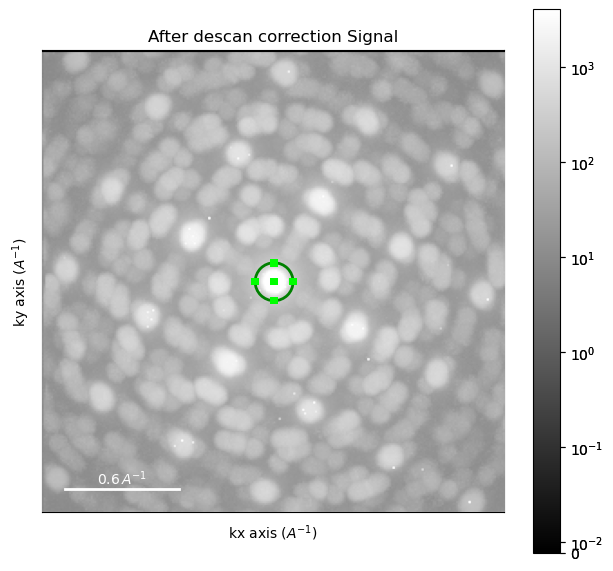

In [12]:
new_max.plot(norm='symlog')
roi = hs.roi.CircleROI(0.0, 0.0, 0.1)
roi.add_widget(new_max)

## Rebin data
Bin the diffraction patterns by 2

In [13]:
s.rebin(scale=(1, 1, 2, 2), out=s, rechunk=False)

## Find masks for reflections

[########################################] | 100% Completed | 167.95 s
Minimum scattering vector: 0.15949382751461458 $A^{-1}$
Maximum scattering vector: 0.7001057239470767 $A^{-1}$
Found 25 blobs


[<Axes: >]

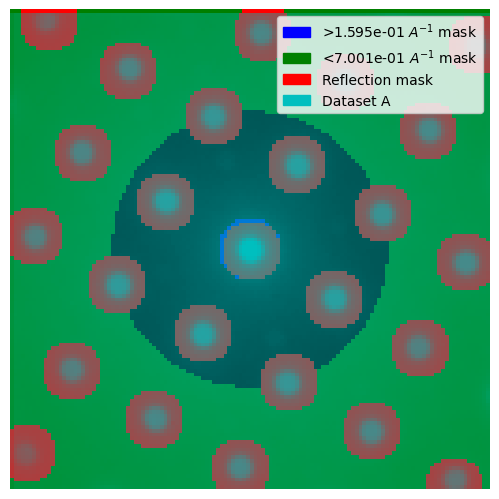

In [15]:
image = s.mean(axis=[0, 1]).deepcopy() #The image to search for blobs in
image.compute()
a = 4.04 #Å
minimum_r = 8 #The minimum radius to set for any mask
cutoff_hkl = np.array([2, 2, 0]) #Make a mask with cutoff at a given HKL
cuton_mrad = 4 #Make a mask that cutsoff everything up a certain mrad

#Set up mask arrays
nx, ny = image.axes_manager.signal_shape
mask = np.zeros((nx, ny), dtype=bool)
direct_beam_mask = np.zeros((nx, ny), dtype=bool)
cutoff_mask = np.zeros((nx, ny), dtype=bool)

#Setting cutoffs
cutoff_g = np.sqrt(np.sum(cutoff_hkl**2 / a**2))
cuton_k = cuton_mrad / 1000 / get_electron_wavelength(image.metadata.Acquisition_instrument.TEM.beam_energy)
print(f'Minimum scattering vector: {cuton_k} {image.axes_manager[0].units}\nMaximum scattering vector: {cutoff_g} {image.axes_manager[0].units}')
X, Y = np.meshgrid(image.axes_manager[0].axis, image.axes_manager[1].axis)
#Set outer cutoff
R = np.sqrt(X**2 + Y**2)
cutoff_mask[R>=cutoff_g] = True
#Set inner cutoff
R = np.sqrt(X**2 + Y**2)
direct_beam_mask[R<=cuton_k] = True

#Mask reflections
blob_kwargs = {
    'min_sigma': 1,
    'max_sigma': 15,
    'num_sigma': 100,
    'overlap': 0,
    'threshold': 15,
}

# Look for blobs (reflections)
blobs = blob_log(image.data, **blob_kwargs)
print(f'Found {len(blobs)} blobs')
xs, ys = np.arange(0, nx), np.arange(0, ny)
X, Y = np.meshgrid(xs, ys)
for blob in blobs:
    y, x, r = blob  # x and y axes are flipped in hyperspy compared to numpy
    r = np.sqrt(2) * r  # Scale blob radius to appear more like a real radius
    r = max([minimum_r, r])  # Make sure that the radius is at least the specified minimum radius
    R = np.sqrt((X - x) ** 2 + (Y - y) ** 2)
    mask[R < r] = True

#Create signals
direct_beam_mask = hs.signals.Signal2D(direct_beam_mask)
direct_beam_mask.metadata.General.title = f'>{cuton_k:.3e} {s.axes_manager[-1].units} mask'

cutoff_mask = hs.signals.Signal2D(cutoff_mask)
cutoff_mask.metadata.General.title = f'<{cutoff_g:.3e} {s.axes_manager[-1].units} mask'

mask = hs.signals.Signal2D(mask)
mask.metadata.General.title = f'Reflection mask'
mask.metadata.add_dictionary({'Preprocessing': {'blob_log': blob_kwargs,
                                                'minimum_r': minimum_r}})

for m in [direct_beam_mask, mask, cutoff_mask]:
    for ax in range(image.axes_manager.signal_dimension):
        m.axes_manager[ax].scale = image.axes_manager[ax].scale
        m.axes_manager[ax].units = image.axes_manager[ax].units
        m.axes_manager[ax].offset = image.axes_manager[ax].offset

# Add metadata
s.metadata.add_dictionary({
    'Preprocessing': {
        'Masks': {
            'Diffraction': {
                'direct_beam': direct_beam_mask,
                'reflections': mask,
                'cutoff': cutoff_mask
            }
        }
    }
})

hs.plot.plot_images(
    [direct_beam_mask*1.0, cutoff_mask*1.0, mask*1.0, image], 
    axes_decor = 'off', 
    overlay = True,
    alphas = [1, 1, 1, 1],
    norm='symlog'
)

## Normalize the data

In [16]:
s.change_dtype('float32')
s = s / s.nanmax(axis=[0, 1, 2, 3])

## Save the preprocessed data

In [17]:
s.save(filename.with_name(f'{filename.stem}_preprocessed.hspy'), overwrite=True)

# Dataset B
This dataset of a 2xxx series aluminium sample in the $[100]$ zone axis was acquired on a JEOL 2100F operated at 200 kV using DigiStar and the P1000 scan generator from NanoMegas. A Merlin EM 1S (Quantum detectors) was used to acquire the diffraction patterns. The nominal parameters for the acquisition were:
|Parameter|Value|
|---------|-----|
|Camera length| 12 cm|
|Mode|NBD|
|Spotsize| 1.0 nm|
|Alpha (condenser minilens)|5|
|Stepsize|2.315 nm|
|Scan rotation|0$^{\circ}$|
|Precession angle| 1.00$^{\circ}$|
|Precession frequency| 100 Hz|
|Exposure time|10 ms|

## Load dataset
Load the dataset, slice it to ROI and set the diffraction calibration

In [18]:
filename = Path(r'Dataset B\datasetB.mib')

In [19]:
s = pxm.load_mib(str(filename), reshape=False)
data = s.data.reshape(512, 512, 256, 256, merge_chunks=False) #Reshape the data
data = data.rechunk(32, 32, 32, 32) #Rechunk the data for "better" processing speeds
s = pxm.signals.LazyElectronDiffraction2D(data) #Recreate a signal from the reshaped data
hdr = filename.with_suffix('.hdr').read_text() #Load the .hdr file
s.original_metadata.add_dictionary({'HDR': hdr}) #Add the .hdr file to the metadata
s.original_metadata.add_dictionary(
    {'NominalParameters': {
        'CL': 12,
        'Mode': 'NBD',
        'Spotsize': 1.0,
        'Alpha': 5,
        'StepSize': (2.315, 2.315),
        'ScanRotation': 0,
        'PrecessionAngle': 1.00,
        'PrecessionFrequency': 100,
    }}) #Add nominal data acquisition parameters to the metadata 
s.metadata.General.title = 'Dataset B' #Update the title of the dataset

C:\Users\emilc\Miniconda3\envs\pyxem0.14.2\lib\site-packages\IPython\core\interactiveshell.py:3373: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  if await self.run_code(code, result, async_=asy):
C:\Users\emilc\Miniconda3\envs\pyxem0.14.2\lib\site-packages\IPython\core\interactiveshell.py:3433: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape

Set experimental parameters

In [20]:
beam_energy = 200 #kV
diffraction_scale = 0.00943 #Å^-1
pixel_size = 55 #um
s.set_experimental_parameters(beam_energy=beam_energy, 
                              camera_length=camera_length(beam_energy, diffraction_scale, pixel_size), 
                              scan_rotation=0, 
                              rocking_angle=1.00, 
                              rocking_frequency=100, 
                              exposure_time=10) #Set the experimental parameters
s.set_scan_calibration(1.7874) #Set the scan calibration to the calibrated scale (from comparison to TEM image in a seperate workflow).
s.set_diffraction_calibration(diffraction_scale) #Set the diffraction calibration (measured on the dataset)

In [21]:
tem_image = hs.load(r'Dataset B/TEMBF.dm4')
s.original_metadata.add_dictionary({'SupportingData': {'TEMBF': tem_image}})

In [22]:
s.save(filename.with_suffix('.hspy'), chunks = s.data.chunksize, overwrite=True) #Save the dataset in .hspy (hdf5) format

In [23]:
s = hs.load(filename.with_suffix('.hspy'), lazy=True) #Reload the dataset

[########################################] | 100% Completed | 2.84 sms


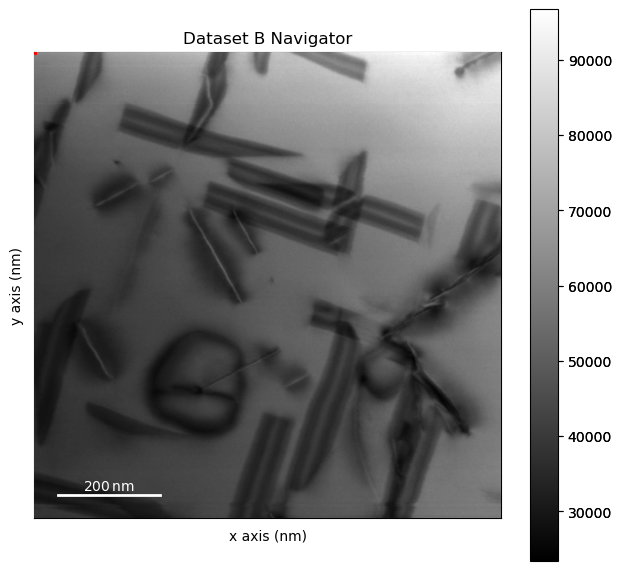

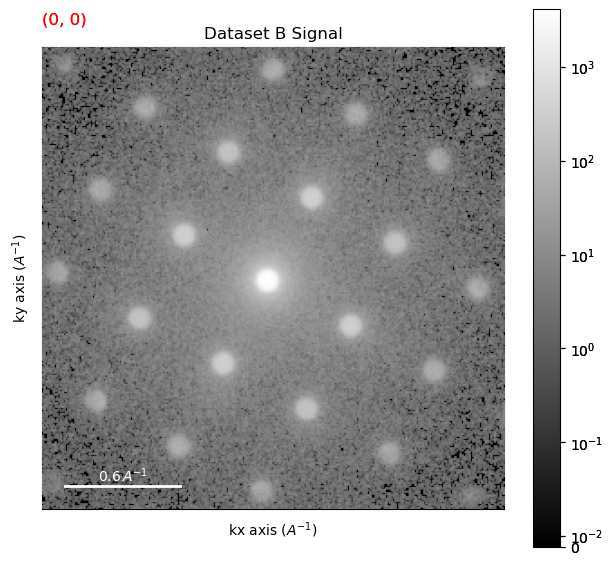

In [24]:
s.plot(norm='symlog') #plot the data with a symlog normalization

## "Correct" linear beam tilt/shift impurity 
(make the direct beam position more stable)

[########################################] | 100% Completed | 130.01 s
[########################################] | 100% Completed | 205.87 s
Beam shift X = ([-4.36258369], [-2.35568366])
Beam shift Y = ([-1.62943614], [0.61830304])


LazyCupyConversion: 'Automatically converting data to cupy array is not supported for lazy signals. Read the corresponding section in the user guide for more information on how to use GPU with lazy signals.'

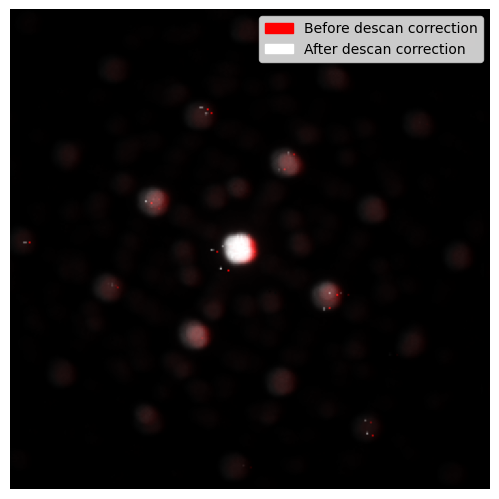

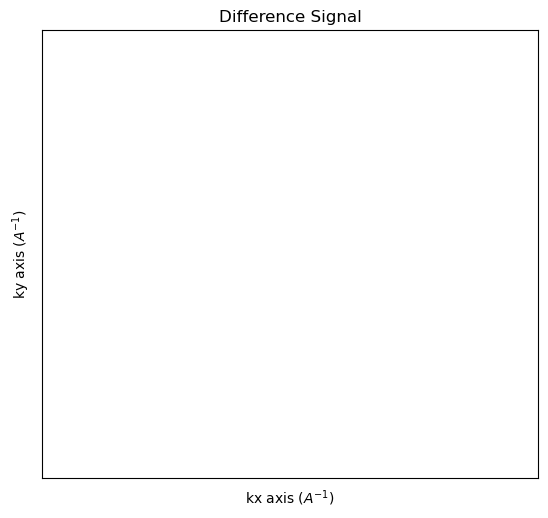

In [25]:
old_max = s.max(axis=[0, 1])
old_max.compute()
old_max.metadata.General.title = 'Before descan correction'
com_mask = (125, 125, 12.5)
com = s.center_of_mass(mask=com_mask)
beam_shift = pxm.signals.BeamShift(com.T)
mask = hs.signals.Signal2D(np.zeros(s.axes_manager.navigation_shape, dtype=bool).T).T
mask.inav[20:-20, 20:-20] = True
beam_shift.make_linear_plane(mask=mask)
beam_shift = beam_shift - (s.axes_manager.signal_shape[0] / 2.0)
print(f'Beam shift X = ({beam_shift.isig[0].min().data}, {beam_shift.isig[0].max().data})\nBeam shift Y = ({beam_shift.isig[1].min().data}, {beam_shift.isig[1].max().data})')
s.center_direct_beam(shifts=beam_shift)
s.metadata.add_dictionary({
        'Preprocessing': {
            'Centering': {
                'COM': com,
                'COM_mask': {
                    'x': com_mask[0],
                    'y': com_mask[1],
                    'r': com_mask[2]
                },
                'Shifts': beam_shift,
                'shift_estimate_mask': mask
            }
        }
    })
new_max = s.max(axis=[0, 1])
new_max.compute()
new_max.metadata.General.title = 'After descan correction'

difference = old_max - new_max
difference.metadata.General.title = 'Difference'

hs.plot.plot_images([old_max, new_max], overlay=True, axes_decor='off', alphas=[1.0, 1.0], colors=['r', 'w'])
difference.plot(cmap='RdBu')

In [ ]:
new_max.plot(norm='symlog')
roi = hs.roi.CircleROI(0.0, 0.0, 0.1)
roi.add_widget(new_max)

## Rebin data
Bin the diffraction patterns by 2

In [ ]:
s.rebin(scale=(1, 1, 2, 2), out=s)

## Find masks for reflections

In [ ]:
image = s.mean(axis=[0, 1]).deepcopy() #The image to search for blobs in
image.compute()
a = 4.04 #Å
minimum_r = 8 #The minimum radius to set for any mask
cutoff_hkl = np.array([2, 2, 0]) #Make a mask with cutoff at a given HKL
cuton_mrad = 4 #Make a mask that cutsoff everything up a certain mrad

#Set up mask arrays
nx, ny = image.axes_manager.signal_shape
mask = np.zeros((nx, ny), dtype=bool)
direct_beam_mask = np.zeros((nx, ny), dtype=bool)
cutoff_mask = np.zeros((nx, ny), dtype=bool)

#Setting cutoffs
cutoff_g = np.sqrt(np.sum(cutoff_hkl**2 / a**2))
cuton_k = cuton_mrad / 1000 / get_electron_wavelength(image.metadata.Acquisition_instrument.TEM.beam_energy)
print(f'Minimum scattering vector: {cuton_k} {image.axes_manager[0].units}\nMaximum scattering vector: {cutoff_g} {image.axes_manager[0].units}')
X, Y = np.meshgrid(image.axes_manager[0].axis, image.axes_manager[1].axis)
#Set outer cutoff
R = np.sqrt(X**2 + Y**2)
cutoff_mask[R>=cutoff_g] = True
#Set inner cutoff
R = np.sqrt(X**2 + Y**2)
direct_beam_mask[R<=cuton_k] = True

#Mask reflections
blob_kwargs = {
    'min_sigma': 1,
    'max_sigma': 15,
    'num_sigma': 100,
    'overlap': 0,
    'threshold': 14.0,
}

# Look for blobs (reflections)
blobs = blob_log(image.data, **blob_kwargs)
print(f'Found {len(blobs)} blobs')
xs, ys = np.arange(0, nx), np.arange(0, ny)
X, Y = np.meshgrid(xs, ys)
for blob in blobs:
    y, x, r = blob  # x and y axes are flipped in hyperspy compared to numpy
    r = np.sqrt(2) * r  # Scale blob radius to appear more like a real radius
    r = max([minimum_r, r])  # Make sure that the radius is at least the specified minimum radius
    R = np.sqrt((X - x) ** 2 + (Y - y) ** 2)
    mask[R < r] = True

#Create signals
direct_beam_mask = hs.signals.Signal2D(direct_beam_mask)
direct_beam_mask.metadata.General.title = f'>{cuton_k:.3e} {s.axes_manager[-1].units} mask'

cutoff_mask = hs.signals.Signal2D(cutoff_mask)
cutoff_mask.metadata.General.title = f'<{cutoff_g:.3e} {s.axes_manager[-1].units} mask'

mask = hs.signals.Signal2D(mask)
mask.metadata.General.title = f'Reflection mask'
mask.metadata.add_dictionary({'Preprocessing': {'blob_log': blob_kwargs,
                                                'minimum_r': minimum_r}})

for m in [direct_beam_mask, mask, cutoff_mask]:
    for ax in range(image.axes_manager.signal_dimension):
        m.axes_manager[ax].scale = image.axes_manager[ax].scale
        m.axes_manager[ax].units = image.axes_manager[ax].units
        m.axes_manager[ax].offset = image.axes_manager[ax].offset

# Add metadata
s.metadata.add_dictionary({
    'Preprocessing': {
        'Masks': {
            'Diffraction': {
                'direct_beam': direct_beam_mask,
                'reflections': mask,
                'cutoff': cutoff_mask
            }
        }
    }
})

hs.plot.plot_images(
    [direct_beam_mask*1.0, cutoff_mask*1.0, mask*1.0, image], 
    axes_decor = 'off', 
    overlay = True,
    alphas = [1, 1, 1, 1],
    norm='symlog'
)

## Normalize the data

In [ ]:
s.change_dtype('float32')
s = s / s.nanmax(axis=[0, 1, 2, 3])

## Save the preprocessed data

In [ ]:
s.save(filename.with_name(f'{filename.stem}_preprocessed.hspy'), overwrite=True)